# Clustering news

This notebook aims to examine the news clustering. First, it reads the news data and convert it into pandas dataframe.

In [1]:
import pandas as pd

file_path = "/Users/amosmbp14/Jupyter notebook/News_classifier/dataset/rel_model_news.xlsx"
df_news = pd.read_excel(file_path)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
df_news.shape

(818, 24)

In [3]:
df_news.columns

Index(['date', 'title', 'body', 'url', 'nb_model_preds',
       'relevancy (yes =1, no=0)', 'scrap fully (Y/N)', 'uri', 'lang',
       'isDuplicate', 'time', 'dateTime', 'dateTimePub', 'dataType', 'sim',
       'source', 'authors', 'image', 'eventUri', 'sentiment', 'wgt',
       'relevance', 'sourceTitle', 'sourceUri'],
      dtype='object')

In [4]:
dataset = df_news[["date","title","body", "isDuplicate"]]
dataset.head()

,date,title,body,isDuplicate
0,2024-02-01,Norway hit by worst storm in 30 years - is cli...,Storm Ingunn follows back to back storms that ...,False
1,2024-02-01,Victims left with 'life-changing' injuries aft...,Superintendent Gabriel Cameron said none of th...,False
2,2024-02-01,Angry farmers invade the streets of Brussels,Farmers are intensifying their pressure on EU ...,False
3,2024-02-01,UK judge dismisses Trump's lawsuit over salaci...,Document released after former president's ina...,False
4,2024-02-01,Social media CEOs testify in heated US Senate ...,Social media CEOs testified this week in a hea...,False


In [5]:
# checking any duplicated news in the dataset
duplicate_count = dataset["isDuplicate"].value_counts()
duplicate_count

isDuplicate
False    818
Name: count, dtype: int64

Comment: No duplicated news is found.

# A. Entity Extraction Function

This project utilises news bodies and keywords to cluster the news. Therefore, this section is generating some functions to extract different types of keywords from the news bodies.

The following is the relevant keywords to cluster the news.

1. PERSON: People, including fictional.
2. NORP: Nationalities or Religious or Political Groups.
3. FAC: Buildings, airports, highways, bridges, etc.
4. ORG: Companies, agencies, institutions, etc.
5. GPE: Countries, cities, states.
6. LOC: Non-GPE locations, mountain ranges, bodies of water.
7. PRODUCT: Objects, vehicles, foods, etc.
8. EVENT: Named hurricanes, battles, wars, sports events, etc.
9. DATE: Absolute or relative dates or periods.

First, it will create functions to extract the above keywords. And the set of keywoards will be stored as a new column 'cluster_kds' as a label in the dataset.

## A1. Keywords Extraction (General)

In [6]:
# Function to extract keywords

import spacy

def extract_keywords(text):
    # loading the spacy's English model
    nlp = spacy.load('en_core_web_sm')

    # process the input text
    doc = nlp(text)

    # set of desired_labels
    desired_labels = {'PERSON', 'NORP', 'FAC',
                     'ORG', 'GPE', 'LOC', 
                      'PRODUCT', 'EVENT','DATE'}

    # set of keeping unique entities, avoid duplicated return
    unique_entities = set()

    # extract entities with desired labels and witout duplicates
    entities = []
    for entity in doc.ents:
        if entity.label_ in desired_labels and entity.text not in unique_entities:
            entities.append((entity.text))
            unique_entities.add(entity.text)

    if not entities:
        return "No entities associated with spaCy 'en_core_web_sm'."
    
    return entities

In [7]:
# Variable to test the function
news_text = "Suella Braverman has said she very much hopes the prime \
minister changes course with his efforts to tackle illegal migration \
after his plan to send asylum seekers to Rwanda was dealt a blow with \
the resignation of Robert Jenrick. The former home secretary, who was \
sacked by Rishi Sunak last month, said she wanted the prime minister to \
succeed in stopping the boats but that he would have to change course and \
take on observations from critics to do that. Ms Braverman, who warned in \
the Commons on Wednesday that the Conservatives faced electoral oblivion \
in a matter of months over the issue, told BBC Radio 4s Today programme: \
I want the prime minister to succeed in stopping the boats. He said he \
would do whatever it takes. I'm telling him there is a way to succeed in \
stopping the boats and fulfilling that promise. If we do it, if he does \
it as prime minister, he will be able to lead us into the next election \
telling the people we have succeeded on this very important pledge. Ms \
Braverman is the latest senior Conservative to pour scorn on the prime \
minister's emergency Rwanda bill, published last night, which compels UK \
judges to treat the African nation as a safe country and gives ministers \
powers to disregard sections of the Human Rights Act. Last night, Mr Sunak \
suffered the resignation of Mr Jenrick over the bill, which he said does \
not go far enough and represented a triumph of hope over experience. On \
Thursday morning, Mr Jenrick was replaced with two people after the \
government carved the role of Minister of State for Immigration into \
Minister for Illegal Migration and Minister for Legal Migration and Delivery. \
Michael Tomlinson was appointed Minister for Illegal Migration while Tom \
Pursglove was moved into the post of Minister for Legal Migration and \
Delivery. Robert Courts is now the new solicitor general after Mr Tomlinson \
was moved from the role. Although the bill allows ministers to disapply \
sections of the Human Rights Act, it does not disregard the entire \
legislation, as some had demanded, and it does not include powers to dismiss \
the whole of the European Convention on Human Rights (ECHR). Ms Braverman \
agreed with Mr Jenrick in saying that the prime minister's bill as it \
currently stands won't work and ultimately will fail. There are elements that \
should be welcomed in this new bill that the prime minister has presented, Ms \
Braverman said. But taken as a whole and looking at the reality of the \
challenges that are involved in detaining people, removing people and \
getting them to Rwanda - this is a very litigious field and there are lots of \
legal frameworks that apply - the reality is, and the sorry truth is, that it \
won't work and it will not stop the boats. She added: You can't tweak at this \
problem. We can't do half measures. We have to totally exclude international \
law - the Refugee Convention, other broader avenues of legal challenge. \
The former home secretary was challenged on her motives for opposing the bill, \
to which she replied that she wanted the prime minister to fulfil the promise \
he made to stop the boats. She indicated that her support for Mr Sunak was \
contingent on adopting a receptive attitude to some of the changes people are \
suggesting and added: There is still time to change this bill. Asked whether \
he could remain as Tory leader if he decided not to change the bill, \
Ms Braverman said: No one is talking about leadership or changing leader. \
Put to her that that was nonsense and pressed on whether she would plot \
against Mr Sunak to remove him, she replied: I want the prime minister to \
succeed in stopping the boats."

In [8]:
extract_keywords(news_text)

['Suella Braverman',
 'Rwanda',
 'Robert Jenrick',
 'Rishi Sunak',
 'last month',
 'Ms Braverman',
 'Wednesday',
 'Conservatives',
 'months',
 'BBC Radio',
 'Today',
 'Conservative',
 'UK',
 'African',
 'Sunak',
 'Jenrick',
 'Thursday',
 'Michael Tomlinson',
 'Tom Pursglove',
 'Robert Courts',
 'Mr Tomlinson',
 'the European Convention on Human Rights (ECHR',
 'Mr Jenrick',
 'the Refugee Convention',
 'Tory']

## A2. Location extraction

In [9]:
# Function to extract locations

import spacy

def extract_location(text):
    # loading the spacy's English model
    nlp = spacy.load('en_core_web_sm')

    # process the input text
    doc = nlp(text)

    # set of desired_labels
    desired_labels = {'FAC','GPE'}

    # set of keeping unique entities, avoid duplicated return
    unique_entities = set()

    # extract entities with desired labels and witout duplicates
    entities = []
    for entity in doc.ents:
        if entity.label_ in desired_labels and entity.text not in unique_entities:
            entities.append((entity.text))
            unique_entities.add(entity.text)

    if not entities:
        return "No entities associated with spaCy 'en_core_web_sm'."
    
    return entities

In [10]:
extract_location(news_text)

['Rwanda', 'UK']

## A3. Organisation extraction

In [11]:
# Function to extract organisation and groups

import spacy

def extract_org(text):
    # loading the spacy's English model
    nlp = spacy.load('en_core_web_sm')

    # process the input text
    doc = nlp(text)

    # set of desired_labels
    desired_labels = {'NORP','ORG'}

    # set of keeping unique entities, avoid duplicated return
    unique_entities = set()

    # extract entities with desired labels and witout duplicates
    entities = []
    for entity in doc.ents:
        if entity.label_ in desired_labels and entity.text not in unique_entities:
            entities.append((entity.text))
            unique_entities.add(entity.text)

    if not entities:
        return "No entities associated with spaCy 'en_core_web_sm'."
    
    return entities

In [12]:
extract_org(news_text)

['Rishi Sunak',
 'Conservatives',
 'BBC Radio',
 'Conservative',
 'African',
 'the European Convention on Human Rights (ECHR',
 'the Refugee Convention',
 'Tory']

## A4. People's name extraction

In [13]:
# Function to extract people

import spacy

def extract_people(text):
    # loading the spacy's English model
    nlp = spacy.load('en_core_web_sm')

    # process the input text
    doc = nlp(text)

    # set of desired_labels
    desired_labels = {'PERSON'}

    # set of keeping unique entities, avoid duplicated return
    unique_entities = set()

    # extract entities with desired labels and witout duplicates
    entities = []
    for entity in doc.ents:
        if entity.label_ in desired_labels and entity.text not in unique_entities:
            entities.append((entity.text))
            unique_entities.add(entity.text)

    if not entities:
        return "No entities associated with spaCy 'en_core_web_sm'."
    
    return entities

In [14]:
extract_people(news_text)

['Suella Braverman',
 'Robert Jenrick',
 'Ms Braverman',
 'Sunak',
 'Jenrick',
 'Michael Tomlinson',
 'Tom Pursglove',
 'Robert Courts',
 'Mr Tomlinson',
 'Mr Jenrick']

## A5. Event Extraction

In [15]:
# Function to extract event

import spacy

def extract_event(text):
    # loading the spacy's English model
    nlp = spacy.load('en_core_web_sm')

    # process the input text
    doc = nlp(text)

    # set of desired_labels
    desired_labels = {'EVENT'}

    # set of keeping unique entities, avoid duplicated return
    unique_entities = set()

    # extract entities with desired labels and witout duplicates
    entities = []
    for entity in doc.ents:
        if entity.label_ in desired_labels and entity.text not in unique_entities:
            entities.append((entity.text))
            unique_entities.add(entity.text)

    if not entities:
        return "No entities associated with spaCy 'en_core_web_sm'."
    
    return entities

In [16]:
extract_event(news_text)

"No entities associated with spaCy 'en_core_web_sm'."

# B. Data preparation

In [17]:
# Extract keywords from the news dataset
dataset['cluster_kds'] = dataset["body"].apply(lambda text: extract_keywords(text))
dataset.head()

/var/folders/y_/_4lmv2450t13fk_011cwcn3h0000gn/T/ipykernel_26369/914272547.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['cluster_kds'] = dataset["body"].apply(lambda text: extract_keywords(text))


,date,title,body,isDuplicate,cluster_kds
0,2024-02-01,Norway hit by worst storm in 30 years - is cli...,Storm Ingunn follows back to back storms that ...,False,"[Storm Ingunn, UK, Ireland, this winter, Norwa..."
1,2024-02-01,Victims left with 'life-changing' injuries aft...,Superintendent Gabriel Cameron said none of th...,False,"[Superintendent Gabriel Cameron, 31-year-old, ..."
2,2024-02-01,Angry farmers invade the streets of Brussels,Farmers are intensifying their pressure on EU ...,False,"[EU, Brussels, today, Europe, Belgian, Italy, ..."
3,2024-02-01,UK judge dismisses Trump's lawsuit over salaci...,Document released after former president's ina...,False,"[Moscow, London, Thursday, US, Donald Trump, B..."
4,2024-02-01,Social media CEOs testify in heated US Senate ...,Social media CEOs testified this week in a hea...,False,"[this week, US Senate, Mark Zuckerberg, US, We..."


In [18]:
dataset["cluster_kds"]

0      [Storm Ingunn, UK, Ireland, this winter, Norwa...
1      [Superintendent Gabriel Cameron, 31-year-old, ...
2      [EU, Brussels, today, Europe, Belgian, Italy, ...
3      [Moscow, London, Thursday, US, Donald Trump, B...
4      [this week, US Senate, Mark Zuckerberg, US, We...
                             ...                        
813    [Moms First, ParentData, AI, the last few year...
814    [Republican, Taylor Swift's, Democratic, Senat...
815    [GOP, Republican, Roughly four months, Jan. 6,...
816    [GOP, Trump, The Supreme Court, Donald Trump's...
817    [months, Chris Murphy, the weekend, Ukraine, C...
Name: cluster_kds, Length: 818, dtype: object

In [19]:
# Convert list of keywords to string
dataset["cluster_kds"] = dataset["cluster_kds"].apply(lambda text: ' '.join(text))
dataset["cluster_kds"]

/var/folders/y_/_4lmv2450t13fk_011cwcn3h0000gn/T/ipykernel_26369/950354066.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["cluster_kds"] = dataset["cluster_kds"].apply(lambda text: ' '.join(text))


0      Storm Ingunn UK Ireland this winter Norway mor...
1      Superintendent Gabriel Cameron 31-year-old thr...
2      EU Brussels today Europe Belgian Italy Europea...
3      Moscow London Thursday US Donald Trump British...
4      this week US Senate Mark Zuckerberg US Wednesd...
                             ...                        
813    Moms First ParentData AI the last few years Mi...
814    Republican Taylor Swift's Democratic Senate 20...
815    GOP Republican Roughly four months Jan. 6 Capi...
816    GOP Trump The Supreme Court Donald Trump's 19t...
817    months Chris Murphy the weekend Ukraine Connec...
Name: cluster_kds, Length: 818, dtype: object

In [20]:
# Display dataset
dataset.head()

,date,title,body,isDuplicate,cluster_kds
0,2024-02-01,Norway hit by worst storm in 30 years - is cli...,Storm Ingunn follows back to back storms that ...,False,Storm Ingunn UK Ireland this winter Norway mor...
1,2024-02-01,Victims left with 'life-changing' injuries aft...,Superintendent Gabriel Cameron said none of th...,False,Superintendent Gabriel Cameron 31-year-old thr...
2,2024-02-01,Angry farmers invade the streets of Brussels,Farmers are intensifying their pressure on EU ...,False,EU Brussels today Europe Belgian Italy Europea...
3,2024-02-01,UK judge dismisses Trump's lawsuit over salaci...,Document released after former president's ina...,False,Moscow London Thursday US Donald Trump British...
4,2024-02-01,Social media CEOs testify in heated US Senate ...,Social media CEOs testified this week in a hea...,False,this week US Senate Mark Zuckerberg US Wednesd...


In [21]:
# Extract location from the news dataset
dataset['location'] = dataset["body"].apply(lambda text: extract_location(text))
dataset['location']

/var/folders/y_/_4lmv2450t13fk_011cwcn3h0000gn/T/ipykernel_26369/103932336.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['location'] = dataset["body"].apply(lambda text: extract_location(text))


0      [UK, Ireland, Norway, Sweden, Britain, Netherl...
1                                      [London, Clapham]
2                             [Brussels, Italy, Ukraine]
3      [Moscow, London, US, Russia, Britain, St Peter...
4                         [US, Missouri, Us, New Mexico]
                             ...                        
813             [Washington D.C., New York, Zelma, U.S.]
814    No entities associated with spaCy 'en_core_web...
815    [Capitol, New York, Missouri, Oregon, Smith, S...
816                                  [the United States]
817    [Ukraine, Connecticut, the United States, Okla...
Name: location, Length: 818, dtype: object

Comment: Some of the row could not extract the location, it apperas "No entities associated with spaCy 'en_core_web_sm'.", such as row 814. So, it should change this sentence into no.

In [22]:
sentence_to_replace = "No entities associated with spaCy 'en_core_web_sm'."

# Define a function to replace the value
def replace_sentence(value):
    if sentence_to_replace in value:
        return ['No']
    else:
        return value

In [23]:
# Replace the sentence
dataset['location'] = dataset['location'].apply(replace_sentence)
dataset['location']

/var/folders/y_/_4lmv2450t13fk_011cwcn3h0000gn/T/ipykernel_26369/2888278236.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['location'] = dataset['location'].apply(replace_sentence)


0      [UK, Ireland, Norway, Sweden, Britain, Netherl...
1                                      [London, Clapham]
2                             [Brussels, Italy, Ukraine]
3      [Moscow, London, US, Russia, Britain, St Peter...
4                         [US, Missouri, Us, New Mexico]
                             ...                        
813             [Washington D.C., New York, Zelma, U.S.]
814                                                 [No]
815    [Capitol, New York, Missouri, Oregon, Smith, S...
816                                  [the United States]
817    [Ukraine, Connecticut, the United States, Okla...
Name: location, Length: 818, dtype: object

In [24]:
# Extract the words from the list
dataset['location'] = dataset['location'].apply(lambda text: ' '.join(text))
dataset['location']

/var/folders/y_/_4lmv2450t13fk_011cwcn3h0000gn/T/ipykernel_26369/4175101886.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['location'] = dataset['location'].apply(lambda text: ' '.join(text))


0      UK Ireland Norway Sweden Britain Netherlands D...
1                                         London Clapham
2                                 Brussels Italy Ukraine
3          Moscow London US Russia Britain St Petersburg
4                              US Missouri Us New Mexico
                             ...                        
813                  Washington D.C. New York Zelma U.S.
814                                                   No
815    Capitol New York Missouri Oregon Smith South C...
816                                    the United States
817    Ukraine Connecticut the United States Oklahoma...
Name: location, Length: 818, dtype: object

Repeat the above step to extract different types of keywords.

In [25]:
# Extract organisation name
dataset['org'] = dataset["body"].apply(lambda text: extract_org(text))
dataset['org'] = dataset['org'].apply(replace_sentence)
dataset['org'] = dataset['org'].apply(lambda text: ' '.join(text))
dataset['org']

/var/folders/y_/_4lmv2450t13fk_011cwcn3h0000gn/T/ipykernel_26369/478624241.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['org'] = dataset["body"].apply(lambda text: extract_org(text))
/var/folders/y_/_4lmv2450t13fk_011cwcn3h0000gn/T/ipykernel_26369/478624241.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['org'] = dataset['org'].apply(replace_sentence)
/var/folders/y_/_4lmv2450t13fk_011cwcn3h0000gn/T/ipykernel_26369/478624241.py:4: SettingWithCopyWarning: 
A value is trying to be s

0      Storm Ingunn Norwegian Scandinavian the UK Met...
1      the Metropolitan Police Scotland Yard Castle t...
2                          EU Belgian European Ukrainian
3      British Trump Orbis Business Intelligence Repu...
4      US Senate Meta TikTok the US Senate Judiciary ...
                             ...                        
813    ParentData AI MidJourney jargon Reshma Supplem...
814    Republican Democratic Senate Time Republicans ...
815    GOP Republican the 9/11 Commission Democrats T...
816    GOP Trump The Supreme Court American the Color...
817    Democrat CNN Politico Senate Republicans Repub...
Name: org, Length: 818, dtype: object

In [26]:
# Extract people name by extract_people
dataset['ppl'] = dataset["body"].apply(lambda text: extract_people(text))
dataset['ppl'] = dataset['ppl'].apply(replace_sentence)
dataset['ppl'] = dataset['ppl'].apply(lambda text: ' '.join(text))
dataset['ppl']

/var/folders/y_/_4lmv2450t13fk_011cwcn3h0000gn/T/ipykernel_26369/2739315631.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['ppl'] = dataset["body"].apply(lambda text: extract_people(text))
/var/folders/y_/_4lmv2450t13fk_011cwcn3h0000gn/T/ipykernel_26369/2739315631.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['ppl'] = dataset['ppl'].apply(replace_sentence)
/var/folders/y_/_4lmv2450t13fk_011cwcn3h0000gn/T/ipykernel_26369/2739315631.py:4: SettingWithCopyWarning: 
A value is trying t

0      kph Ingunn Aidan McGivern Storm Jocelyn Storm ...
1      Superintendent Gabriel Cameron Alexander Castl...
2                                                     No
3      Donald Trump Karen Steyn Christopher Steele Hu...
4      Mark Zuckerberg Zuckerberg Dick Durbin Josh Ha...
                             ...                        
813                                     Moms First Emily
814    Taylor Swift's Swift Travis Kelce Kelce Pfizer...
815    John Katko Kevin McCarthy Katko Jason Smith Ro...
816                                 Donald Trump's Trump
817    Chris Murphy Murphy Donald Trump Joe Biden Mik...
Name: ppl, Length: 818, dtype: object

In [27]:
# Extract event by extract_event
dataset['event'] = dataset["body"].apply(lambda text: extract_event(text))
dataset['event'] = dataset['event'].apply(replace_sentence)
dataset['event'] = dataset['event'].apply(lambda text: ' '.join(text))
dataset['event']

/var/folders/y_/_4lmv2450t13fk_011cwcn3h0000gn/T/ipykernel_26369/2047807359.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['event'] = dataset["body"].apply(lambda text: extract_event(text))
/var/folders/y_/_4lmv2450t13fk_011cwcn3h0000gn/T/ipykernel_26369/2047807359.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['event'] = dataset['event'].apply(replace_sentence)
/var/folders/y_/_4lmv2450t13fk_011cwcn3h0000gn/T/ipykernel_26369/2047807359.py:4: SettingWithCopyWarning: 
A value is try

0          New Year's
1                  No
2                  No
3                  No
4                  No
            ...      
813                No
814    the Super Bowl
815                No
816                No
817                No
Name: event, Length: 818, dtype: object

After that, it displays the charateristic of each separated keywords type.

In [28]:
dataset['location'].value_counts()['No']

85

In [29]:
dataset['org'].value_counts()['No']

22

In [30]:
dataset['ppl'].value_counts()['No']

62

In [31]:
dataset['event'].value_counts()['No']

720

It seems that event column is not a good feature to cluster the news as 720/817 articles do not include event that the 'SpaCy' package could extract. 

# C. KMean clustering

In [32]:
dataset.columns

Index(['date', 'title', 'body', 'isDuplicate', 'cluster_kds', 'location',
       'org', 'ppl', 'event'],
      dtype='object')

In [33]:
# Initialize dataset for Kmean Clustering
kmean_data = dataset[['date','title','body','cluster_kds',
                     'location', 'org', 'ppl']]
kmean_data.head(2)

,date,title,body,cluster_kds,location,org,ppl
0,2024-02-01,Norway hit by worst storm in 30 years - is cli...,Storm Ingunn follows back to back storms that ...,Storm Ingunn UK Ireland this winter Norway mor...,UK Ireland Norway Sweden Britain Netherlands D...,Storm Ingunn Norwegian Scandinavian the UK Met...,kph Ingunn Aidan McGivern Storm Jocelyn Storm ...
1,2024-02-01,Victims left with 'life-changing' injuries aft...,Superintendent Gabriel Cameron said none of th...,Superintendent Gabriel Cameron 31-year-old thr...,London Clapham,the Metropolitan Police Scotland Yard Castle t...,Superintendent Gabriel Cameron Alexander Castl...


## C1. KMean clustering on news title, body and keywords

/Users/amosmbp14/opt/anaconda3/envs/pytorch_transformers_spacy/lib/python3.9/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


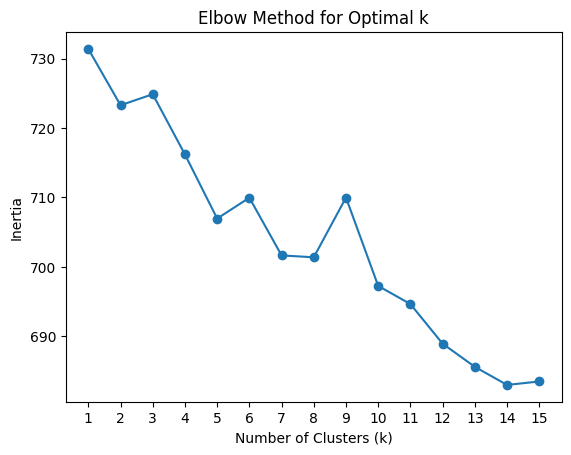

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Step 1: Select text columns for vectorization
text_cols = ['title','body','cluster_kds']
text_data = kmean_data[text_cols]

# Step 2: Vectorize the text using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
keyword_vectors = tfidf_vectorizer.fit_transform(text_data.apply(lambda x: ' '.join(x), axis=1))

# Step 3: Find the optimal number of clusters (k)
inertia = []
k_values = range(1, 16)
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(keyword_vectors)
    inertia.append(kmeans.inertia_)

# Step 4: Plot the inertia (sum of squared distances to the nearest centroid) vs. k
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.show()


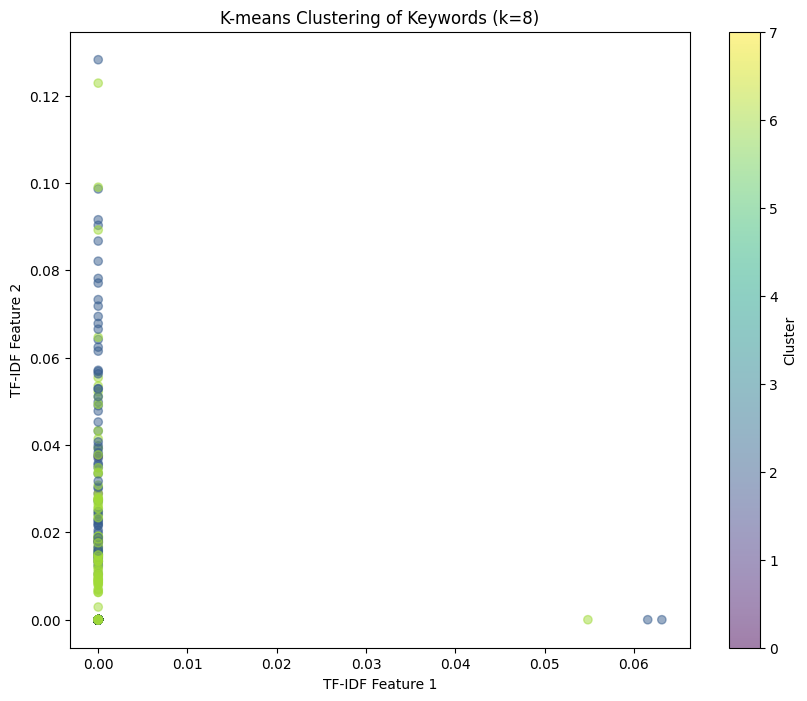

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Step 1: Select text columns for vectorization
text_cols = ['title','body','cluster_kds']
text_data = kmean_data[text_cols]

# Step 2: Vectorize the text using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
keyword_vectors = tfidf_vectorizer.fit_transform(text_data.apply(lambda x: ' '.join(x), axis=1))

# Step 3: Perform K-means clustering with optimal k
k = 8
kmeans_1 = KMeans(n_clusters=k)
kmeans_1.fit(keyword_vectors)
kmeans_1_labels = kmeans_1.labels_

# Step 4: Visualize the clusters
plt.figure(figsize=(10, 8))
plt.scatter(keyword_vectors[:, 0].toarray(), keyword_vectors[:, 1].toarray(), c=kmeans_1_labels, cmap='viridis', alpha=0.5)
plt.title(f'K-means Clustering of Keywords (k={k})')
plt.xlabel('TF-IDF Feature 1')
plt.ylabel('TF-IDF Feature 2')
plt.colorbar(label='Cluster')
plt.show()

## C2. KMean clustering on news title, body and keywords with dimensionality

Find the optimal k value and set pca is 2.

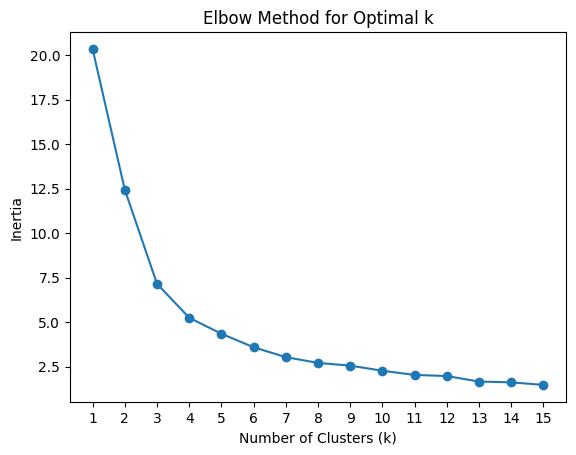

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Step 1: Select text columns for vectorization
text_cols = ['title','body','cluster_kds']
text_data = kmean_data[text_cols]

# Step 2: Vectorizer the text using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
keyword_vectors = tfidf_vectorizer.fit_transform(text_data.apply(lambda x: ' '.join(x), axis=1))

# Step 3: Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_keyword_vectors = pca.fit_transform(keyword_vectors.toarray())

# Step 4: Find the optimal number of clusters (k)
inertia = []
k_values = range(1, 16) 
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(reduced_keyword_vectors)
    inertia.append(kmeans.inertia_)

# Step 5: Plot the inertia (sum of squared distances to the nearest centroid) vs. k
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.show()

Comment: 7 would be the optimal k.

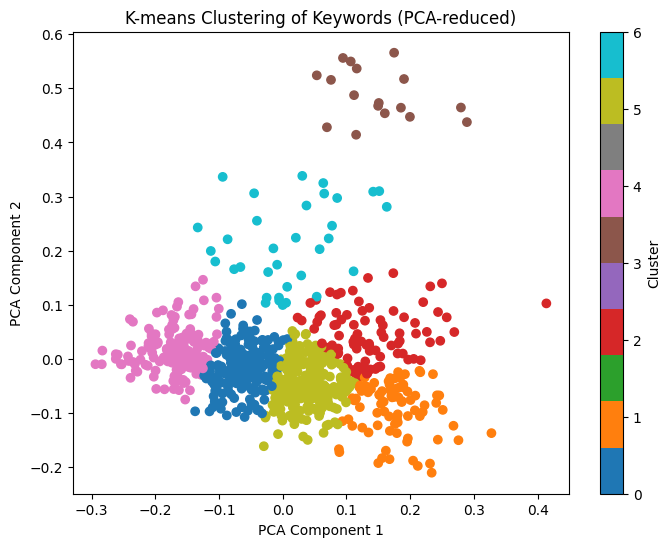

In [37]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Perform K-means clustering
kmeans_2 = KMeans(n_clusters= 7)  # You can choose the number of clusters based on your data and requirements
kmeans_2.fit(reduced_keyword_vectors)
kmeans_2_labels = kmeans_2.labels_

# Visualize the clusters
plt.figure(figsize=(8, 6))
plt.scatter(reduced_keyword_vectors[:, 0], reduced_keyword_vectors[:, 1], c=kmeans_2_labels, cmap='tab10')
plt.title('K-means Clustering of Keywords (PCA-reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

## C3. KMean clustering on keywords

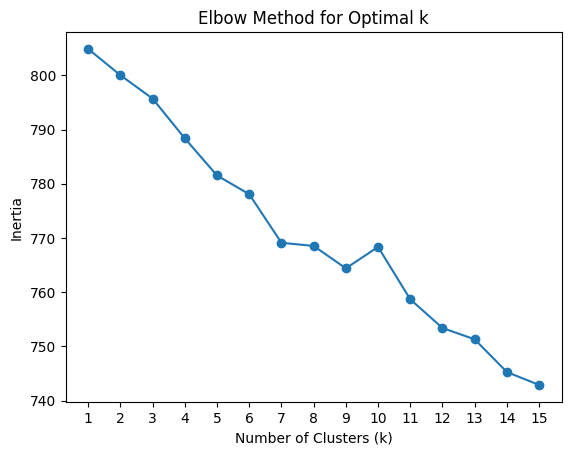

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Step 1: Select text columns for vectorization
text_cols = ['location','org','ppl']
text_data = kmean_data[text_cols]

# Step 2: Vectorize the text using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
keyword_vectors = tfidf_vectorizer.fit_transform(text_data.apply(lambda x: ' '.join(x), axis=1))

# Step 3: Find the optimal number of clusters (k)
inertia = []
k_values = range(1, 16)
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(keyword_vectors)
    inertia.append(kmeans.inertia_)

# Step 4: Plot the inertia (sum of squared distances to the nearest centroid) vs. k
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.show()


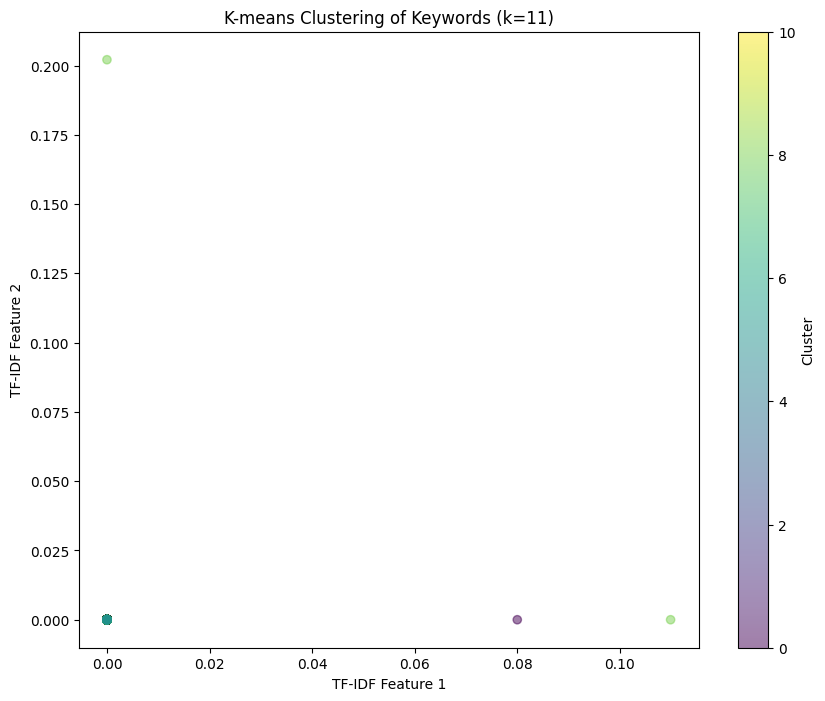

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Step 1: Select text columns for vectorization
text_cols = ['location','org','ppl']
text_data = kmean_data[text_cols]

# Step 2: Vectorize the text using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
keyword_vectors = tfidf_vectorizer.fit_transform(text_data.apply(lambda x: ' '.join(x), axis=1))

# Step 3: Perform K-means clustering with optimal k (k=8)
k = 11
kmeans_3 = KMeans(n_clusters=k)
kmeans_3.fit(keyword_vectors)
kmeans_3_labels = kmeans_3.labels_

# Step 4: Visualize the clusters
plt.figure(figsize=(10, 8))
plt.scatter(keyword_vectors[:, 0].toarray(), keyword_vectors[:, 1].toarray(), c=kmeans_3_labels, cmap='viridis', alpha=0.5)
plt.title(f'K-means Clustering of Keywords (k={k})')
plt.xlabel('TF-IDF Feature 1')
plt.ylabel('TF-IDF Feature 2')
plt.colorbar(label='Cluster')
plt.show()

Change 'cluster_kds' to replace the above separated keywords.

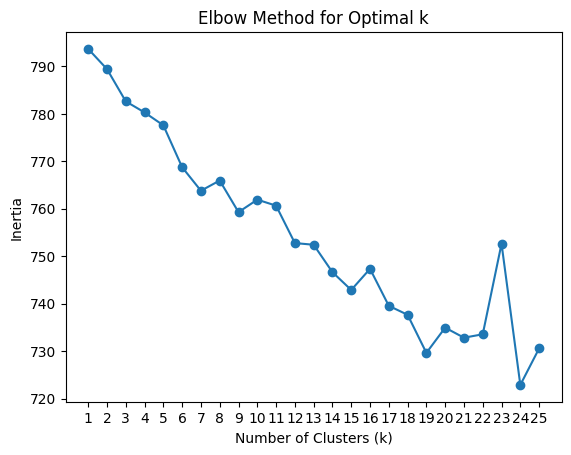

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Step 1: Select text columns for vectorization
text_cols = ['cluster_kds']
text_data = kmean_data[text_cols]

# Step 2: Vectorize the text using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
keyword_vectors = tfidf_vectorizer.fit_transform(text_data.apply(lambda x: ' '.join(x), axis=1))

# Step 3: Find the optimal number of clusters (k)
inertia = []
k_values = range(1, 26)
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(keyword_vectors)
    inertia.append(kmeans.inertia_)

# Step 4: Plot the inertia (sum of squared distances to the nearest centroid) vs. k
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.show()


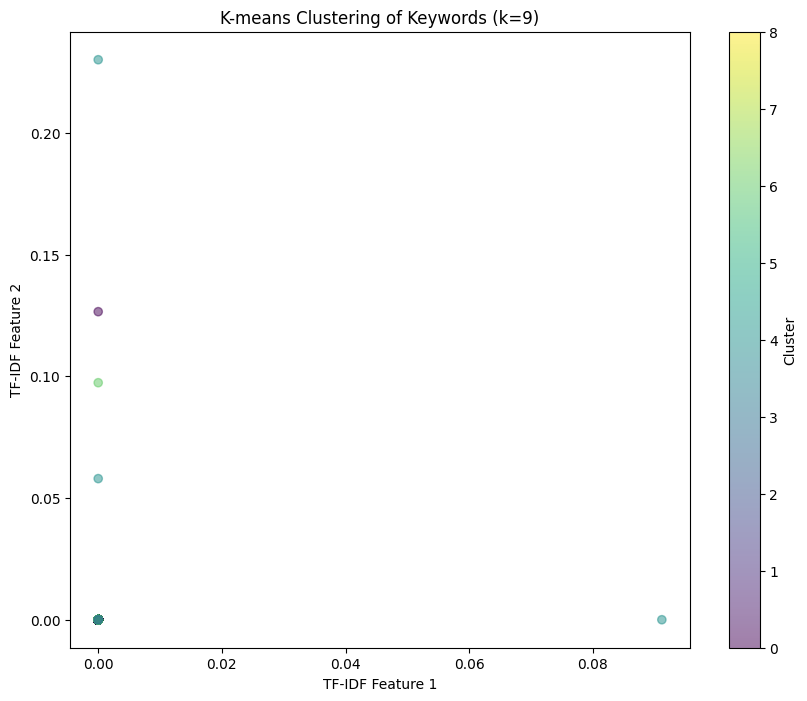

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Step 1: Select text columns for vectorization
text_cols = ['cluster_kds']
text_data = kmean_data[text_cols]

# Step 2: Vectorize the text using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
keyword_vectors = tfidf_vectorizer.fit_transform(text_data.apply(lambda x: ' '.join(x), axis=1))

# Step 3: Perform K-means clustering with optimal k (k=8)
k = 9
kmeans_4 = KMeans(n_clusters=k)
kmeans_4.fit(keyword_vectors)
kmeans_4_labels = kmeans_4.labels_

# Step 4: Visualize the clusters
plt.figure(figsize=(10, 8))
plt.scatter(keyword_vectors[:, 0].toarray(), keyword_vectors[:, 1].toarray(), c=kmeans_4_labels, cmap='viridis', alpha=0.5)
plt.title(f'K-means Clustering of Keywords (k={k})')
plt.xlabel('TF-IDF Feature 1')
plt.ylabel('TF-IDF Feature 2')
plt.colorbar(label='Cluster')
plt.show()

## C4. KMean Clustering on separated keywords with reduced dimensionality

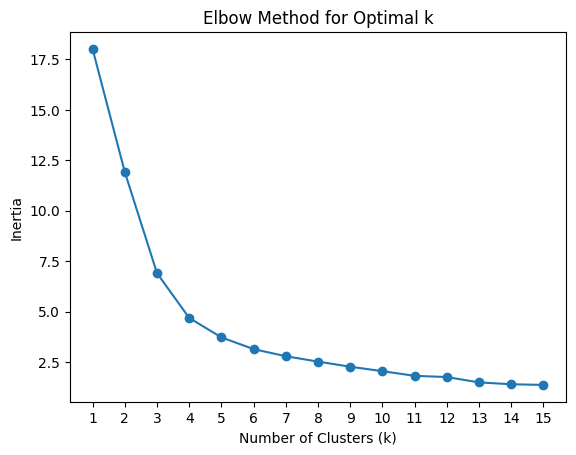

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Step 1: Select text columns for vectorization
text_cols = ['cluster_kds']
text_data = kmean_data[text_cols]

# Step 2: Vectorizer the text using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
keyword_vectors = tfidf_vectorizer.fit_transform(text_data.apply(lambda x: ' '.join(x), axis=1))

# Step 3: Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_keyword_vectors = pca.fit_transform(keyword_vectors.toarray())

# Step 4: Find the optimal number of clusters (k)
inertia = []
k_values = range(1, 16) 
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(reduced_keyword_vectors)
    inertia.append(kmeans.inertia_)

# Step 5: Plot the inertia (sum of squared distances to the nearest centroid) vs. k
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.show()

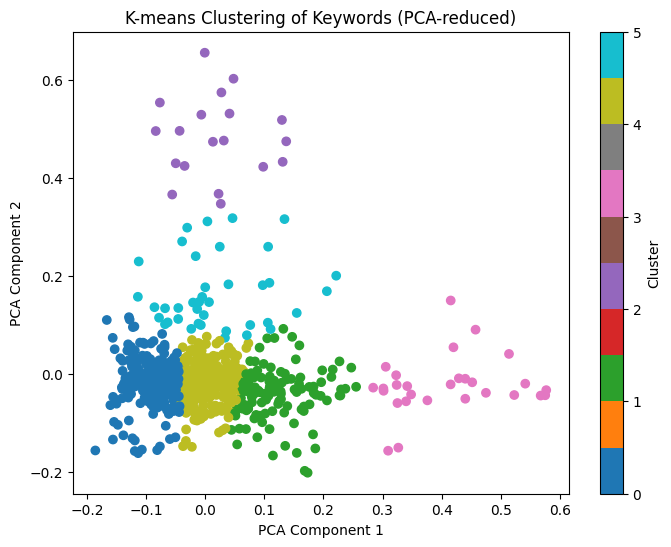

In [43]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Perform K-means clustering
kmeans_5 = KMeans(n_clusters= 6)  # You can choose the number of clusters based on your data and requirements
kmeans_5.fit(reduced_keyword_vectors)
kmeans_5_labels = kmeans_5.labels_

# Visualize the clusters
plt.figure(figsize=(8, 6))
plt.scatter(reduced_keyword_vectors[:, 0], reduced_keyword_vectors[:, 1], c=kmeans_5_labels, cmap='tab10')
plt.title('K-means Clustering of Keywords (PCA-reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

Change to separated keywords 'location', 'org', 'ppl'

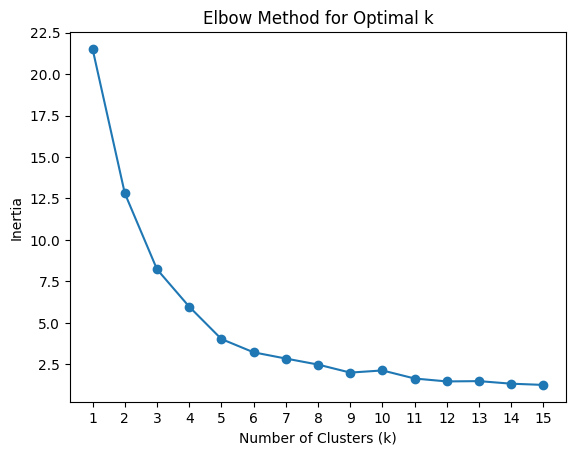

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Step 1: Select text columns for vectorization
text_cols = ['location','org','ppl']
text_data = kmean_data[text_cols]

# Step 2: Vectorizer the text using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
keyword_vectors = tfidf_vectorizer.fit_transform(text_data.apply(lambda x: ' '.join(x), axis=1))

# Step 3: Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_keyword_vectors = pca.fit_transform(keyword_vectors.toarray())

# Step 4: Find the optimal number of clusters (k)
inertia = []
k_values = range(1, 16) 
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(reduced_keyword_vectors)
    inertia.append(kmeans.inertia_)

# Step 5: Plot the inertia (sum of squared distances to the nearest centroid) vs. k
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.show()

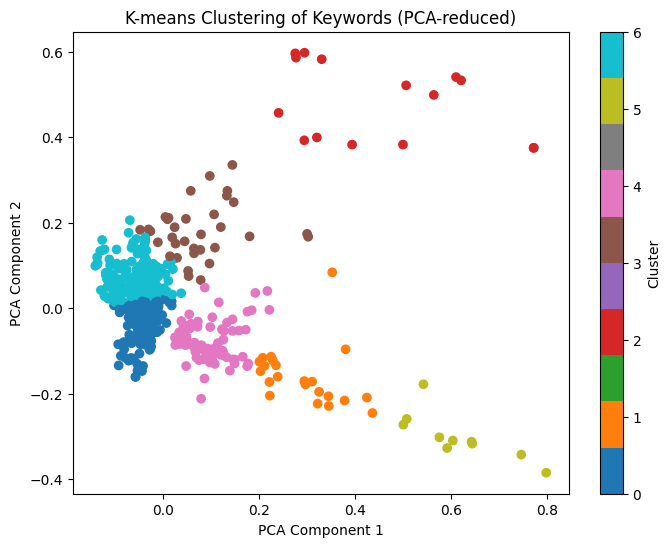

In [45]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Perform K-means clustering
kmeans_6 = KMeans(n_clusters= 7)  # You can choose the number of clusters based on your data and requirements
kmeans_6.fit(reduced_keyword_vectors)
kmeans_6_labels = kmeans_6.labels_

# Visualize the clusters
plt.figure(figsize=(8, 6))
plt.scatter(reduced_keyword_vectors[:, 0], reduced_keyword_vectors[:, 1], c=kmeans_6_labels, cmap='tab10')
plt.title('K-means Clustering of Keywords (PCA-reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

# D. DBSCAN Clustering

1. eps = maximum distance between 2 data points.
2. min_samples = numbers of data points to be a core point of cluster.

In [46]:
dbscan_data = dataset[['date','title','body','cluster_kds','location','org','ppl']]
dbscan_data.head(3)

,date,title,body,cluster_kds,location,org,ppl
0,2024-02-01,Norway hit by worst storm in 30 years - is cli...,Storm Ingunn follows back to back storms that ...,Storm Ingunn UK Ireland this winter Norway mor...,UK Ireland Norway Sweden Britain Netherlands D...,Storm Ingunn Norwegian Scandinavian the UK Met...,kph Ingunn Aidan McGivern Storm Jocelyn Storm ...
1,2024-02-01,Victims left with 'life-changing' injuries aft...,Superintendent Gabriel Cameron said none of th...,Superintendent Gabriel Cameron 31-year-old thr...,London Clapham,the Metropolitan Police Scotland Yard Castle t...,Superintendent Gabriel Cameron Alexander Castl...
2,2024-02-01,Angry farmers invade the streets of Brussels,Farmers are intensifying their pressure on EU ...,EU Brussels today Europe Belgian Italy Europea...,Brussels Italy Ukraine,EU Belgian European Ukrainian,No


## D1. DBSCAN clustering on news title, body and keywords

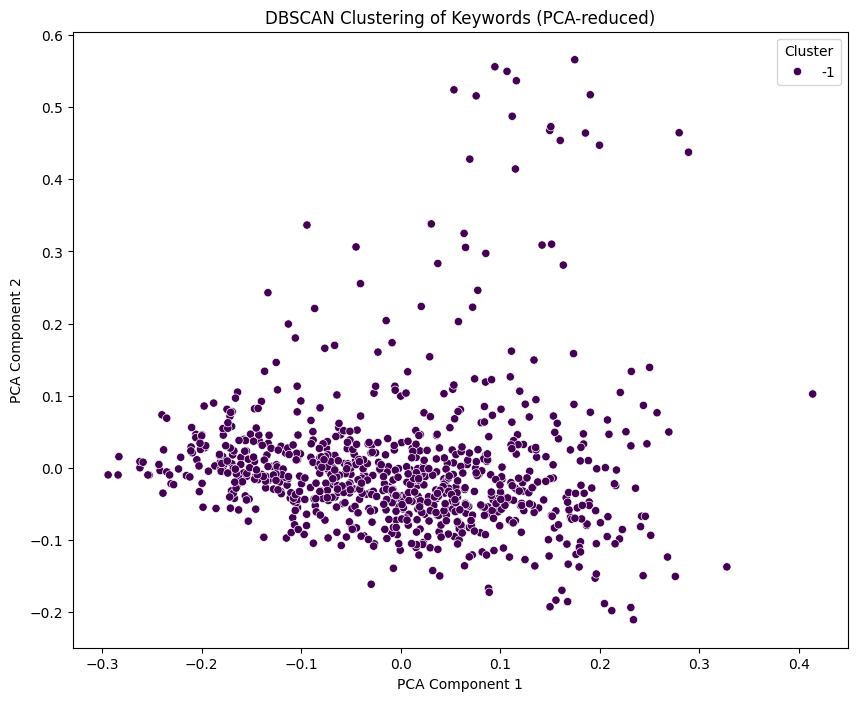

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Select text columns for vectorization
text_cols = ['title', 'body', 'cluster_kds']
text_data = dbscan_data[text_cols]

# Step 2: Vectorize the text using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
keyword_vectors = tfidf_vectorizer.fit_transform(text_data.apply(lambda x: ' '.join(x), axis=1))

# Step 3: Perform dimensionality reduction with PCA
pca = PCA(n_components=3)
reduced_keyword_vectors = pca.fit_transform(keyword_vectors.toarray())

# Step 4: Perform DBSCAN clustering
eps = 0.76  # Set the neighborhood radius
min_samples = 20  # Set the minimum number of samples in a neighborhood
dbscan_1 = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_1_cluster = dbscan_1.fit_predict(keyword_vectors)

# Step 5: Visualize the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x=reduced_keyword_vectors[:, 0], y=reduced_keyword_vectors[:, 1], hue=dbscan_1_cluster, palette='viridis', legend='full')
plt.title('DBSCAN Clustering of Keywords (PCA-reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster', loc='upper right')
plt.show()


## D2. DBSCAN clustering on news title, body and keywords with dimensionality

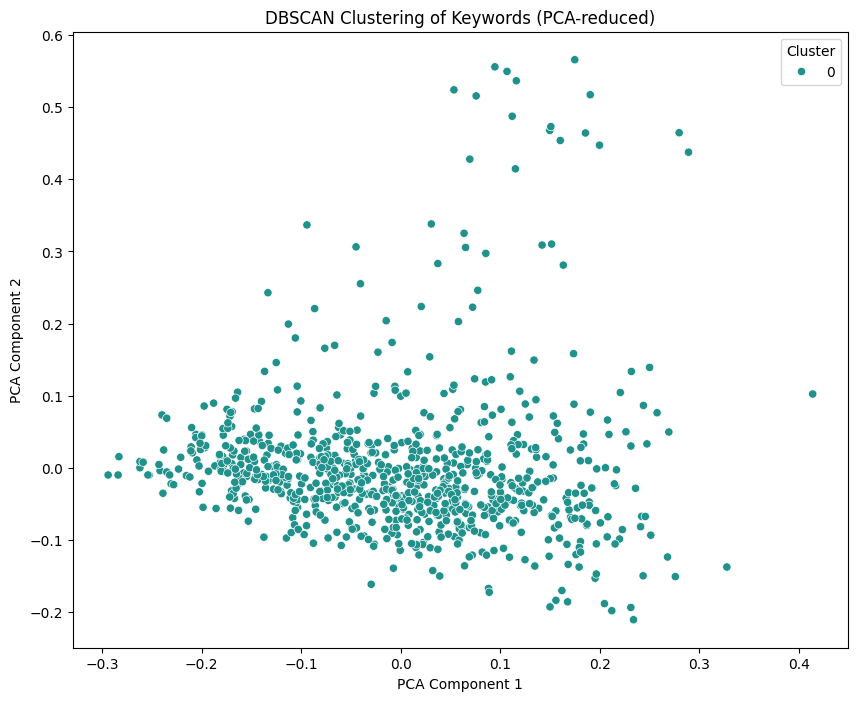

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Select text columns for vectorization
text_cols = ['title', 'body', 'cluster_kds']
text_data = dbscan_data[text_cols]

# Step 2: Vectorize the text using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
keyword_vectors = tfidf_vectorizer.fit_transform(text_data.apply(lambda x: ' '.join(x), axis=1))

# Step 3: Perform dimensionality reduction with PCA
pca = PCA(n_components=2)  # You can choose the number of components based on your preference
reduced_keyword_vectors = pca.fit_transform(keyword_vectors.toarray())

# Step 4: Perform DBSCAN clustering
eps = 0.5  # Set the neighborhood radius
min_samples = 70  # Set the minimum number of samples in a neighborhood
dbscan_2 = DBSCAN(eps=eps, min_samples=min_samples)
# Using the reduced dimensionality of text vectors
dbscan_2_cluster = dbscan_2.fit_predict(reduced_keyword_vectors)

# Step 5: Visualize the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x=reduced_keyword_vectors[:, 0], y=reduced_keyword_vectors[:, 1], hue=dbscan_2_cluster, palette='viridis', legend='full')
plt.title('DBSCAN Clustering of Keywords (PCA-reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster', loc='upper right')
plt.show()


## D3. DBSCAN clustering on separated keywords with reduced dimensionality

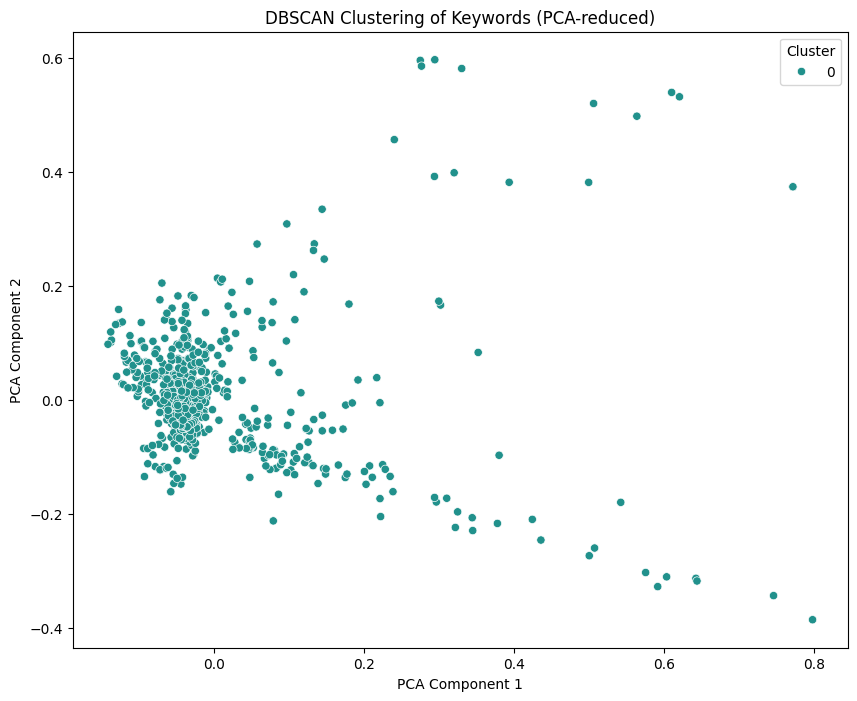

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Select text columns for vectorization
text_cols = ['location','org','ppl']
text_data = dbscan_data[text_cols]

# Step 2: Vectorize the text using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
keyword_vectors = tfidf_vectorizer.fit_transform(text_data.apply(lambda x: ' '.join(x), axis=1))

# Step 3: Perform dimensionality reduction with PCA
pca = PCA(n_components=2)
reduced_keyword_vectors = pca.fit_transform(keyword_vectors.toarray())

# Step 4: Perform DBSCAN clustering
eps = 0.76  # Set the neighborhood radius
min_samples = 20  # Set the minimum number of samples in a neighborhood
dbscan_3 = DBSCAN(eps=eps, min_samples=min_samples)
# Using the reduced dimensionality text vectors
dbscan_3_cluster = dbscan_3.fit_predict(reduced_keyword_vectors)

# Step 5: Visualize the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x=reduced_keyword_vectors[:, 0], y=reduced_keyword_vectors[:, 1], hue=dbscan_3_cluster, palette='viridis', legend='full')
plt.title('DBSCAN Clustering of Keywords (PCA-reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster', loc='upper right')
plt.show()


Try one clustering to use 'cluster_kds', instead of using the above separated keywords.

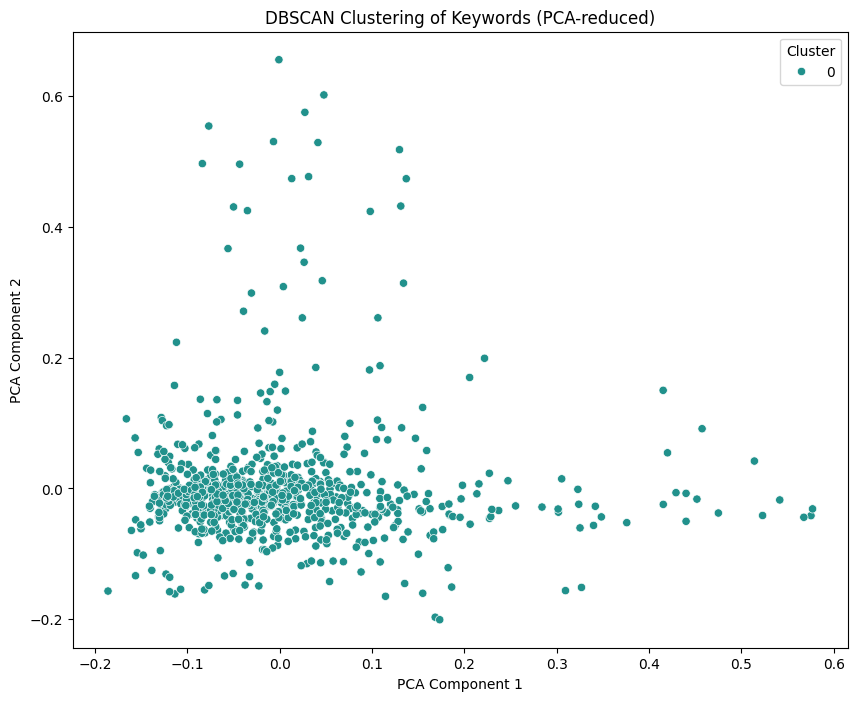

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Select text columns for vectorization
text_cols = ['cluster_kds']
text_data = dbscan_data[text_cols]

# Step 2: Vectorize the text using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
keyword_vectors = tfidf_vectorizer.fit_transform(text_data.apply(lambda x: ' '.join(x), axis=1))

# Step 3: Perform dimensionality reduction with PCA
pca = PCA(n_components=2)
reduced_keyword_vectors = pca.fit_transform(keyword_vectors.toarray())

# Step 4: Perform DBSCAN clustering
eps = 0.76  # Set the neighborhood radius
min_samples = 20  # Set the minimum number of samples in a neighborhood
dbscan_4 = DBSCAN(eps=eps, min_samples=min_samples)
# Using the reduced dimensionality text vectors
dbscan_4_cluster = dbscan_4.fit_predict(reduced_keyword_vectors)

# Step 5: Visualize the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x=reduced_keyword_vectors[:, 0], y=reduced_keyword_vectors[:, 1], hue=dbscan_4_cluster, palette='viridis', legend='full')
plt.title('DBSCAN Clustering of Keywords (PCA-reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster', loc='upper right')
plt.show()


## D4. DBSCAN with UMAP dimensionality reduction

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


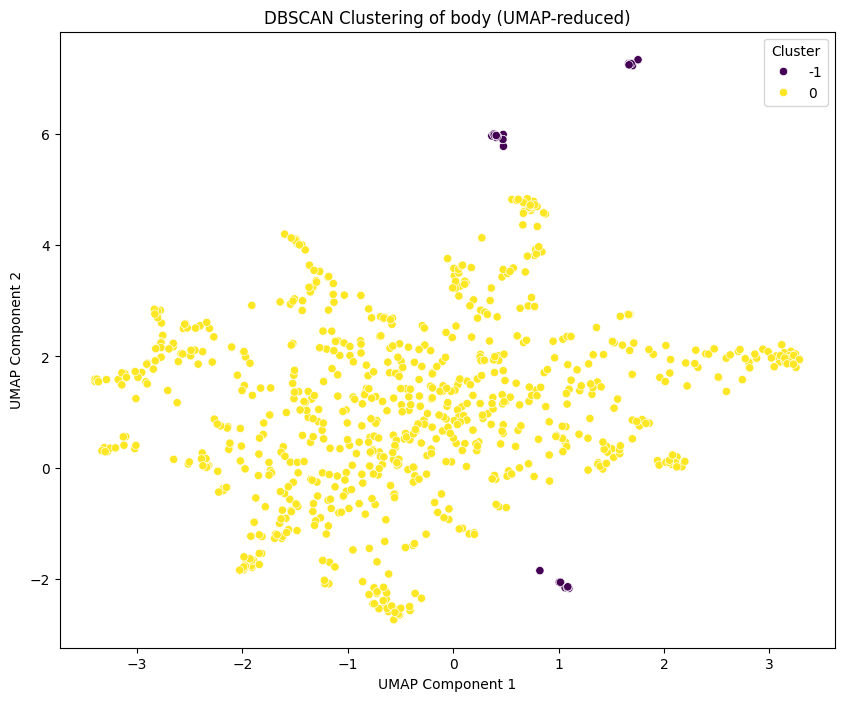

In [117]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Select text columns for vectorization
text_cols = ['body']
text_data = dbscan_data[text_cols]

# Step 2: Vectorize the text using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
keyword_vectors = tfidf_vectorizer.fit_transform(text_data.apply(lambda x: ' '.join(x), axis=1))

# Step 3: Perform dimensionality reduction with UMAP
umap_model = UMAP(n_components=2)
reduced_keyword_vectors = umap_model.fit_transform(keyword_vectors.toarray())

# Step 4: Perform DBSCAN clustering
eps = 0.76  # Set the neighborhood radius
min_samples = 20  # Set the minimum number of samples in a neighborhood
dbscan_5 = DBSCAN(eps=eps, min_samples=min_samples)
# Using the reduced dimensionality text vectors
dbscan_5_cluster = dbscan_5.fit_predict(reduced_keyword_vectors)

# Step 5: Visualize the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x=reduced_keyword_vectors[:, 0], y=reduced_keyword_vectors[:, 1], 
                hue=dbscan_5_cluster, palette='viridis', legend='full')
plt.title('DBSCAN Clustering of body (UMAP-reduced)')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Cluster', loc='upper right')
plt.show()


Try for keywords

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


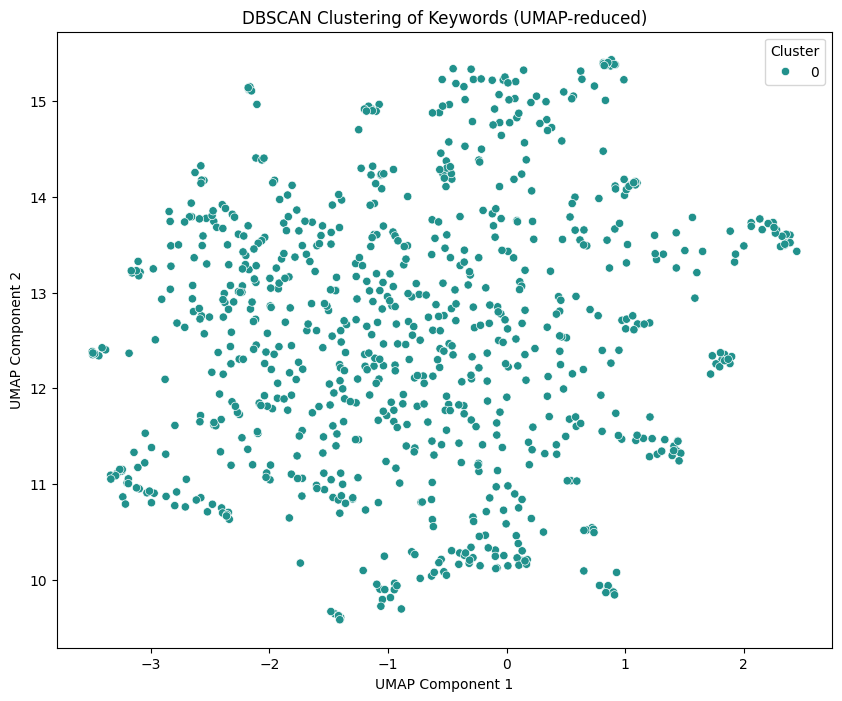

In [118]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Select text columns for vectorization
text_cols = ['cluster_kds']
text_data = dbscan_data[text_cols]

# Step 2: Vectorize the text using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
keyword_vectors = tfidf_vectorizer.fit_transform(text_data.apply(lambda x: ' '.join(x), axis=1))

# Step 3: Perform dimensionality reduction with UMAP
umap_model = UMAP(n_components=2)
reduced_keyword_vectors = umap_model.fit_transform(keyword_vectors.toarray())

# Step 4: Perform DBSCAN clustering
eps = 0.76  # Set the neighborhood radius
min_samples = 20  # Set the minimum number of samples in a neighborhood
dbscan_6 = DBSCAN(eps=eps, min_samples=min_samples)
# Using the reduced dimensionality text vectors
dbscan_6_cluster = dbscan_6.fit_predict(reduced_keyword_vectors)

# Step 5: Visualize the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x=reduced_keyword_vectors[:, 0], y=reduced_keyword_vectors[:, 1], 
                hue=dbscan_6_cluster, palette='viridis', legend='full')
plt.title('DBSCAN Clustering of Keywords (UMAP-reduced)')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Cluster', loc='upper right')
plt.show()


Comment: DBSCAN is not able to cluster this textual dataset. 

# E. Affinity Propagation 

## E1. Affinity Propagation clustering on news title, body and keywords

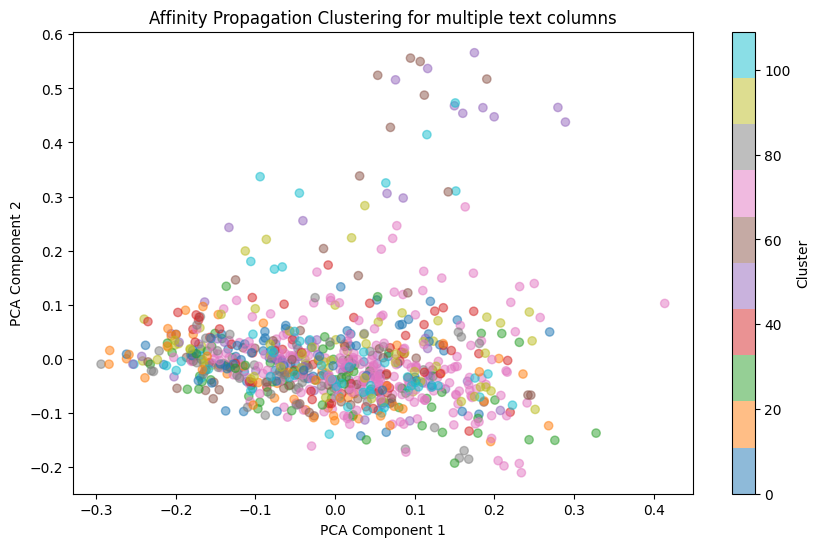

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AffinityPropagation
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Concatenate text columns for vectorization
text_columns = ['title','body','cluster_kds']
text_data = dbscan_data[text_columns]
text_data_concatenated = text_data.apply(lambda x: ' '.join(x), axis=1)

# Vectorize concatenated text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
text_vectors = tfidf_vectorizer.fit_transform(text_data_concatenated)

# Perform dimensionality reduction for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(text_vectors.toarray())

# Perform Affinity Propagation clustering
affinity_propagation = AffinityPropagation()
ap_1 = affinity_propagation.fit_predict(text_vectors)

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=ap_1, cmap='tab10', alpha=0.5)
plt.title('Affinity Propagation Clustering for multiple text columns')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

## E2. Affinity Propagation clustering on news title, body and keywords with reduced dimensionality

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


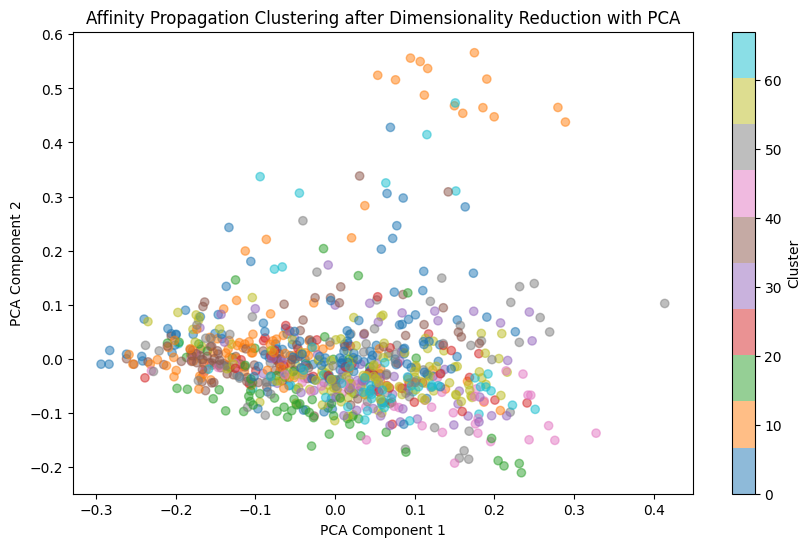

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AffinityPropagation
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Concatenate text columns for vectorization
text_columns = ['title', 'body', 'cluster_kds']
text_data = dbscan_data[text_columns]
text_data_concatenated = text_data.apply(lambda x: ' '.join(x), axis=1)

# Vectorize concatenated text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
text_vectors = tfidf_vectorizer.fit_transform(text_data_concatenated)

# Perform dimensionality reduction with PCA
pca = PCA(n_components=50)  # Adjust the number of components as needed
reduced_text_vectors = pca.fit_transform(text_vectors.toarray())

# Perform Affinity Propagation clustering
affinity_propagation = AffinityPropagation()
ap_2 = affinity_propagation.fit_predict(reduced_text_vectors)

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(reduced_text_vectors[:, 0], reduced_text_vectors[:, 1], c=ap_2, cmap='tab10', alpha=0.5)
plt.title('Affinity Propagation Clustering after Dimensionality Reduction with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()


## E3. Affinity Propagation clustering on keywords with dimensionality reduction

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


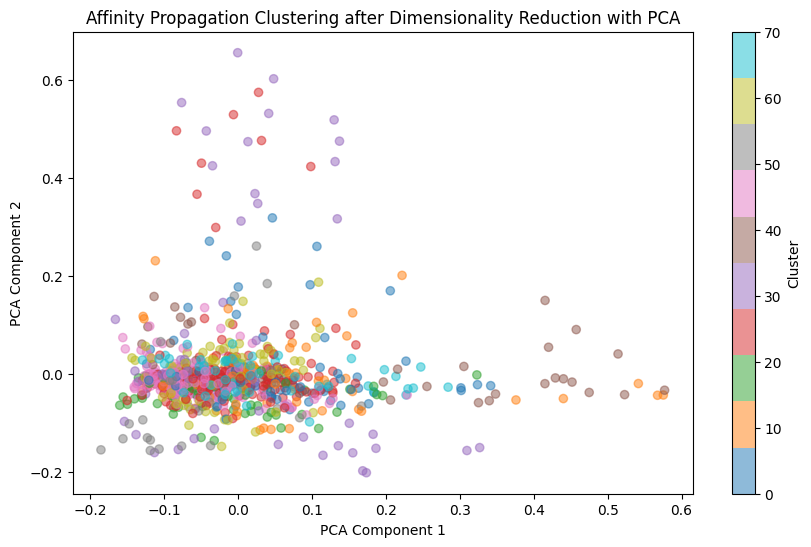

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AffinityPropagation
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Concatenate text columns for vectorization
text_columns = ['cluster_kds']
text_data = dbscan_data[text_columns]
text_data_concatenated = text_data.apply(lambda x: ' '.join(x), axis=1)

# Vectorize concatenated text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
text_vectors = tfidf_vectorizer.fit_transform(text_data_concatenated)

# Perform dimensionality reduction with PCA
pca = PCA(n_components=50)  # Adjust the number of components as needed
reduced_text_vectors = pca.fit_transform(text_vectors.toarray())

# Perform Affinity Propagation clustering
affinity_propagation = AffinityPropagation()
ap_3 = affinity_propagation.fit_predict(reduced_text_vectors)

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(reduced_text_vectors[:, 0], reduced_text_vectors[:, 1], c=ap_3, cmap='tab10', alpha=0.5)
plt.title('Affinity Propagation Clustering after Dimensionality Reduction with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()


Try to use separated keywords, instead of using 'cluster_kds'.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


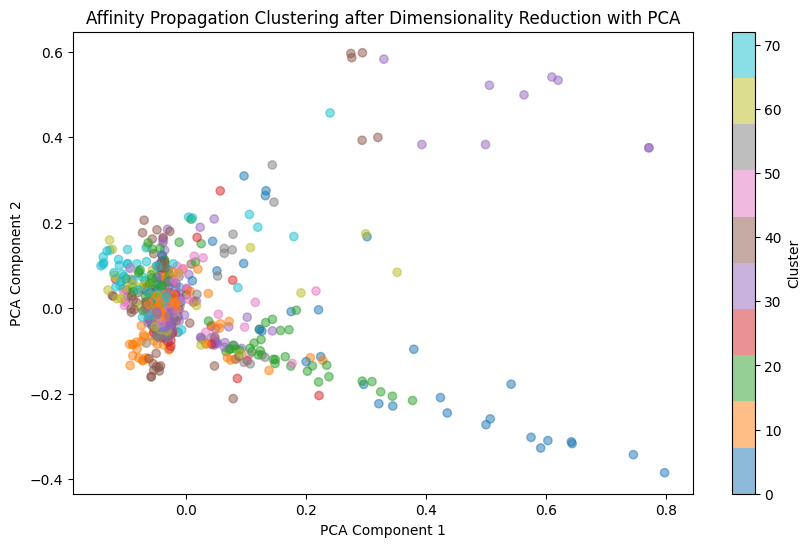

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AffinityPropagation
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Concatenate text columns for vectorization
text_columns = ['location','org','ppl']
text_data = dbscan_data[text_columns]
text_data_concatenated = text_data.apply(lambda x: ' '.join(x), axis=1)

# Vectorize concatenated text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
text_vectors = tfidf_vectorizer.fit_transform(text_data_concatenated)

# Perform dimensionality reduction with PCA
pca = PCA(n_components=50)  # Adjust the number of components as needed
reduced_text_vectors = pca.fit_transform(text_vectors.toarray())

# Perform Affinity Propagation clustering
affinity_propagation = AffinityPropagation()
ap_4 = affinity_propagation.fit_predict(reduced_text_vectors)

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(reduced_text_vectors[:, 0], reduced_text_vectors[:, 1], c=ap_4, cmap='tab10', alpha=0.5)
plt.title('Affinity Propagation Clustering after Dimensionality Reduction with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()


Overall, it is not good for the performance as no separated clusters could be found. Change the dimensionality to UMAP.

## E4. Affinity Propagation clustering on body with dimensionality reduction

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/Users/amosmbp14/opt/anaconda3/envs/pytorch_transformers_spacy/lib/python3.9/site-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning:

Affinity propagation did not converge, this model may return degenerate cluster centers and labels.



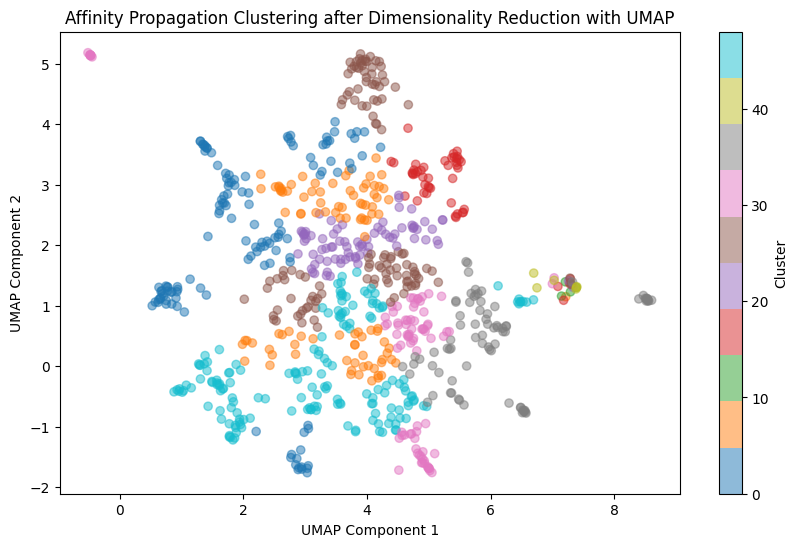

In [109]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AffinityPropagation
from umap import UMAP
import matplotlib.pyplot as plt

# Concatenate text columns for vectorization
text_columns = ['body']
text_data = dbscan_data[text_columns]
text_data_concatenated = text_data.apply(lambda x: ' '.join(x), axis=1)

# Vectorize concatenated text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
text_vectors = tfidf_vectorizer.fit_transform(text_data_concatenated)

# Perform dimensionality reduction with UMAP
umap_model = UMAP(n_components=2)  # Adjust the number of components as needed
reduced_text_vectors = umap_model.fit_transform(text_vectors.toarray())

# Perform Affinity Propagation clustering
affinity_propagation = AffinityPropagation()
ap_5 = affinity_propagation.fit_predict(reduced_text_vectors)

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(reduced_text_vectors[:, 0], reduced_text_vectors[:, 1], c=ap_5, cmap='tab10', alpha=0.5)
plt.title('Affinity Propagation Clustering after Dimensionality Reduction with UMAP')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.colorbar(label='Cluster')
plt.show()


And try to use keywords

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


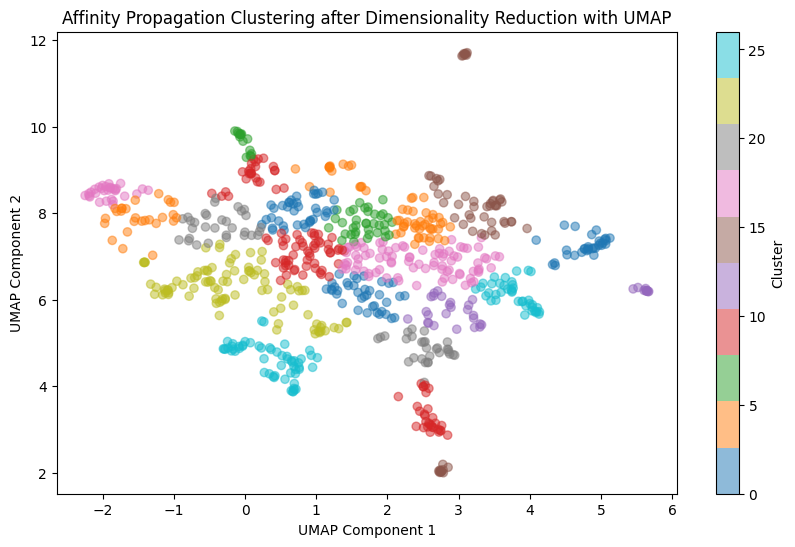

In [110]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AffinityPropagation
from umap import UMAP
import matplotlib.pyplot as plt

# Concatenate text columns for vectorization
text_columns = ['body']
text_data = dbscan_data[text_columns]
text_data_concatenated = text_data.apply(lambda x: ' '.join(x), axis=1)

# Vectorize concatenated text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
text_vectors = tfidf_vectorizer.fit_transform(text_data_concatenated)

# Perform dimensionality reduction with UMAP
umap_model = UMAP(n_components=2)  # Adjust the number of components as needed
reduced_text_vectors = umap_model.fit_transform(text_vectors.toarray())

# Perform Affinity Propagation clustering
affinity_propagation = AffinityPropagation()
ap_6 = affinity_propagation.fit_predict(reduced_text_vectors)

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(reduced_text_vectors[:, 0], reduced_text_vectors[:, 1], c=ap_6, cmap='tab10', alpha=0.5)
plt.title('Affinity Propagation Clustering after Dimensionality Reduction with UMAP')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.colorbar(label='Cluster')
plt.show()


Comment: It seems that if using keywords for affinity propagation clustering by UMAP dimensionality reduction, the clusters are more separated and compacted. Using the statistic to compare the model.

In [112]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Compute silhouette score for both clustering results
silhouette_score_1 = silhouette_score(reduced_text_vectors, ap_5)
silhouette_score_2 = silhouette_score(reduced_text_vectors, ap_6)

# Compute Calinski-Harabasz index for both clustering results
calinski_harabasz_score_1 = calinski_harabasz_score(reduced_text_vectors, ap_5)
calinski_harabasz_score_2 = calinski_harabasz_score(reduced_text_vectors, ap_6)

# Compute Davies-Bouldin index for both clustering results
davies_bouldin_score_1 = davies_bouldin_score(reduced_text_vectors, ap_5)
davies_bouldin_score_2 = davies_bouldin_score(reduced_text_vectors, ap_6)

# Print the results
print("Clustering 1 using body:")
print(f"Silhouette Score: {silhouette_score_1}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_score_1}")
print(f"Davies-Bouldin Index: {davies_bouldin_score_1}")

print("\nClustering 2 using keywords:")
print(f"Silhouette Score: {silhouette_score_2}")
print(f"Calinski-Harabasz Index: {calinski_harabasz_score_2}")
print(f"Davies-Bouldin Index: {davies_bouldin_score_2}")


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Clustering 1 using body:
Silhouette Score: 0.21515552699565887
Calinski-Harabasz Index: 183.64772474438124
Davies-Bouldin Index: 1.1453560304121693

Clustering 2 using keywords:
Silhouette Score: 0.4126392602920532
Calinski-Harabasz Index: 1056.899670205361
Davies-Bouldin Index: 0.7067025541595534


Comment: As it can be seen, clustering 2 using keywords has greater similarity of object to its own clusters and the more separated clusters.  

In [113]:
dbscan_data['clustering_label'] = ap_6
dbscan_data['clustering_label'].value_counts()

/var/folders/y_/_4lmv2450t13fk_011cwcn3h0000gn/T/ipykernel_26369/2048590413.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



clustering_label
9     55
16    44
17    42
22    42
5     41
26    40
13    40
1     39
2     38
7     37
25    34
0     32
20    31
8     30
18    30
19    30
3     27
23    27
10    26
12    25
21    24
24    23
4     16
6     15
15    12
11    10
14     8
Name: count, dtype: int64

In [114]:
dbscan_data.to_excel('clustering_results.xlsx', index=False)

# F. HDBSCAN

Unlike DBSCAN, HDBSCAN can determine the number of clusters automatically. Using the UMAP (Uniform Manifold Approximation and Projection), a non-linear dimensionality reduction technqiue

Using the UMAP (Uniform Manifold Approximation and Projection), a non-linear dimensionality reduction technqiue, it is effective to capture complex relationship in high-dimensional data.

## F1. HDBSCAN on news articles bodies

In [56]:
hd_df = dataset
hd_df.head()

,date,title,body,isDuplicate,cluster_kds,location,org,ppl,event
0,2024-02-01,Norway hit by worst storm in 30 years - is cli...,Storm Ingunn follows back to back storms that ...,False,Storm Ingunn UK Ireland this winter Norway mor...,UK Ireland Norway Sweden Britain Netherlands D...,Storm Ingunn Norwegian Scandinavian the UK Met...,kph Ingunn Aidan McGivern Storm Jocelyn Storm ...,New Year's
1,2024-02-01,Victims left with 'life-changing' injuries aft...,Superintendent Gabriel Cameron said none of th...,False,Superintendent Gabriel Cameron 31-year-old thr...,London Clapham,the Metropolitan Police Scotland Yard Castle t...,Superintendent Gabriel Cameron Alexander Castl...,No
2,2024-02-01,Angry farmers invade the streets of Brussels,Farmers are intensifying their pressure on EU ...,False,EU Brussels today Europe Belgian Italy Europea...,Brussels Italy Ukraine,EU Belgian European Ukrainian,No,No
3,2024-02-01,UK judge dismisses Trump's lawsuit over salaci...,Document released after former president's ina...,False,Moscow London Thursday US Donald Trump British...,Moscow London US Russia Britain St Petersburg,British Trump Orbis Business Intelligence Repu...,Donald Trump Karen Steyn Christopher Steele Hu...,No
4,2024-02-01,Social media CEOs testify in heated US Senate ...,Social media CEOs testified this week in a hea...,False,this week US Senate Mark Zuckerberg US Wednesd...,US Missouri Us New Mexico,US Senate Meta TikTok the US Senate Judiciary ...,Mark Zuckerberg Zuckerberg Dick Durbin Josh Ha...,No


Embedding:

In [57]:
from sentence_transformers import SentenceTransformer

# Download the sentence embedding model
embedder = SentenceTransformer('all-mpnet-base-v2')

# embed article body
corpus_embeddings = embedder.encode(hd_df['body'].values)
corpus_embeddings.shape

/Users/amosmbp14/opt/anaconda3/envs/pytorch_transformers_spacy/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(818, 768)

In [58]:
import umap

# Reduce the dimensions of embeddings using UMAP
reduced_embeddings = umap.UMAP(n_components=2,
                              n_neighbors=100,
                              min_dist=0.02).fit_transform(corpus_embeddings)

# put the values of 2 dimensions inside the dataframe
hd_df["x"] = reduced_embeddings[:, 0]
hd_df["y"] = reduced_embeddings[:, 1]

# substring the full body, for visualisation purpose
hd_df["body_short"] = hd_df["body"].str[:100]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/var/folders/y_/_4lmv2450t13fk_011cwcn3h0000gn/T/ipykernel_26369/554935754.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hd_df["x"] = reduced_embeddings[:, 0]
/var/folders/y_/_4lmv2450t13fk_011cwcn3h0000gn/T/ipykernel_26369/554935754.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hd_df["y"] = reduced_embeddings[:, 1]
/var/folders/y_/_4lmv2450t13fk_011cwcn3h0000gn/T/ipykernel_26369/554935754.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

Start the clustering:

In [59]:
import hdbscan

# clustering with HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=9)
labels = clusterer.fit_predict(reduced_embeddings)
hd_df["label"] = [str(label) for label in labels]
print(f"Num of clusters: {labels.max()}")

Num of clusters: 16


/var/folders/y_/_4lmv2450t13fk_011cwcn3h0000gn/T/ipykernel_26369/3340862700.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hd_df["label"] = [str(label) for label in labels]


Filter out the outliers that could not be clustered.

In [60]:
# number of outliers
num_outliers = len(hd_df[hd_df["label"] == "-1"])
print(f"Num of outliers: {num_outliers} ({num_outliers / len(hd_df) * 100:.2f} % of total)")

Num of outliers: 232 (28.36 % of total)


Comment: Not bad only 28% of data point could not be clustered. 72% of data point could be clustered by the algorithm.

In [61]:
# remove outliers
hd_df_outliers = hd_df[hd_df["label"] != "-1"]
hd_df_outliers = hd_df_outliers[["body_short", "x","y","label"]]
hd_df_outliers.head()

,body_short,x,y,label
0,Storm Ingunn follows back to back storms that ...,16.350138,11.979378,12
1,Superintendent Gabriel Cameron said none of th...,15.744720,8.907993,4
2,Farmers are intensifying their pressure on EU ...,16.841789,12.468118,5
3,Document released after former president's ina...,17.788216,10.775319,8
4,Social media CEOs testified this week in a hea...,16.710178,10.429979,7


Visualise the data without outliers.

In [65]:
import plotly.express as px

# scatter plot for HDBSCAN without outlier
hover_data = {
    "body_short": True,
    "x": False,
    "y": False
}

# generate the figure
fig = px.scatter(hd_df_outliers, x="x", y="y", template="plotly_dark",
                   title="HDBSCAN Embeddings (removed outliers)", color="label", hover_data=hover_data)


Visualise ALL data.

In [66]:
# scatter plot
hover_data_2 = {
    "body_short": True,
    "x": False,
    "y": False
}

# generate the figure
fig_2 = px.scatter(hd_df, x="x", y="y", template="plotly_dark",
                   title="HDBSCAN Embeddings", color="label", hover_data=hover_data_2)


Let's visualise the clustering result if the outliers are removed.

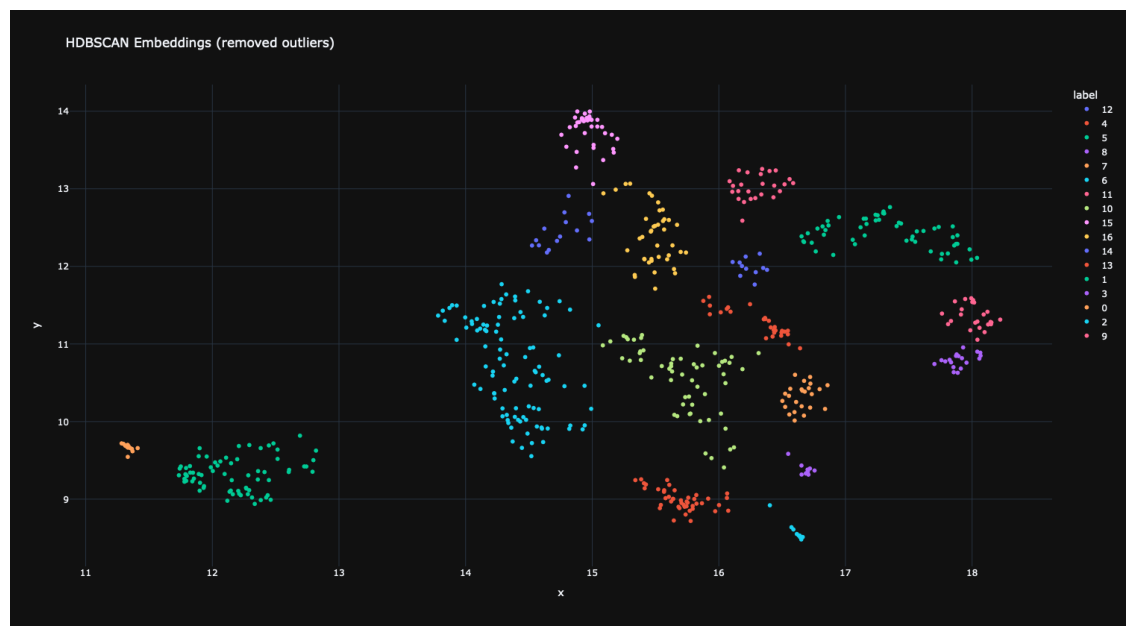

In [132]:
import matplotlib.pyplot as plt

# Read the PNG file
img = plt.imread("hdbscan_body_noout.png")

# Display the image
plt.figure(figsize=(20, 8)) 
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

And it visalises the clustering result for all datapoints.

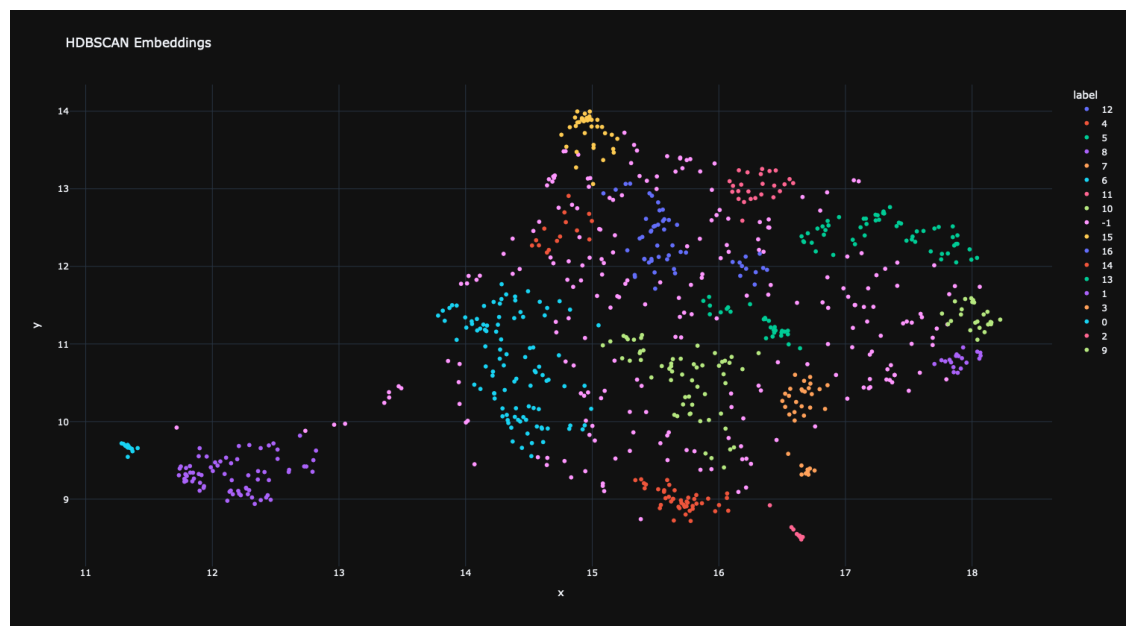

In [137]:
import matplotlib.pyplot as plt

# Read the PNG file
img_2 = plt.imread("hdbscan_body_alldata.png")

# Display the image
plt.figure(figsize=(20, 8)) 
plt.imshow(img_2)
plt.axis('off')  # Hide axes
plt.show()

Commment: It has a huge improved clustering performance by HDBSCAN. The clusters are separated in distance and the density of each cluster is not to low. 

In [75]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, homogeneity_completeness_v_measure

# Compute silhouette score
silhouette = silhouette_score(reduced_embeddings, labels)
print(f'Silhouette Score: {silhouette}')

# Compute Calinski-Harabasz index
calinski_harabasz = calinski_harabasz_score(reduced_embeddings, labels)
print(f'Calinski-Harabasz Index: {calinski_harabasz}')

# Compute Davies-Bouldin index
davies_bouldin = davies_bouldin_score(reduced_embeddings, labels)
print(f'Davies-Bouldin Index: {davies_bouldin}')

Silhouette Score: 0.16675567626953125
Calinski-Harabasz Index: 179.76154799768403
Davies-Bouldin Index: 1.3125696386927483
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [80]:
import pandas as pd

label_counts = hd_df['label'].value_counts().to_frame()
print(label_counts)

       count
label       
-1       232
6         99
1         71
10        58
5         55
4         44
16        41
15        37
13        28
11        25
9         24
7         24
8         19
14        15
0         14
2         11
12        11
3         10


## F2. HDBSCAN on keywords

In [90]:
hd_df_2 = hd_df
hd_df_2.columns

Index(['date', 'title', 'body', 'isDuplicate', 'cluster_kds', 'location',
       'org', 'ppl', 'event', 'x', 'y', 'body_short', 'label'],
      dtype='object')

In [92]:
hd_df_2 = hd_df.drop(['x','y','body_short','label'], axis=1)
hd_df_2.columns

Index(['date', 'title', 'body', 'isDuplicate', 'cluster_kds', 'location',
       'org', 'ppl', 'event'],
      dtype='object')

Embedding:

In [93]:
from sentence_transformers import SentenceTransformer

# Download the sentence embedding model
embedder = SentenceTransformer('all-mpnet-base-v2')

# embed article body
corpus_embeddings_2 = embedder.encode(hd_df_2['cluster_kds'].values)
corpus_embeddings_2.shape

(818, 768)

In [94]:
import umap

# Reduce the dimensions of embeddings using UMAP
reduced_embeddings_2 = umap.UMAP(n_components=2,
                              n_neighbors=100,
                              min_dist=0.02).fit_transform(corpus_embeddings_2)

# put the values of 2 dimensions inside the dataframe
hd_df_2["x"] = reduced_embeddings_2[:, 0]
hd_df_2["y"] = reduced_embeddings_2[:, 1]

# substring the full body, for visualisation purpose
hd_df_2["kds_short"] = hd_df_2["cluster_kds"].str[:100]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Start the clustering:

In [95]:
import hdbscan

# clustering with HDBSCAN
clusterer_2 = hdbscan.HDBSCAN(min_cluster_size=9)
labels_kds = clusterer.fit_predict(reduced_embeddings_2)
hd_df_2["label"] = [str(label) for label in labels_kds]
print(f"Num of clusters: {labels_kds.max()}")

Num of clusters: 3


Filter out the outliers that could not be clustered.

In [96]:
# number of outliers
num_outliers_kds = len(hd_df_2[hd_df_2["label"] == "-1"])
print(f"Num of outliers: {num_outliers_kds} ({num_outliers_kds / len(hd_df) * 100:.2f} % of total)")

Num of outliers: 41 (5.01 % of total)


Comment: Not bad only 28% of data point could not be clustered. 72% of data point could be clustered by the algorithm.

In [97]:
# remove outliers
hd_df_outliers_2 = hd_df_2[hd_df_2["label"] != "-1"]
hd_df_outliers_2 = hd_df_outliers_2[["kds_short", "x","y","label"]]
hd_df_outliers_2.head()

,kds_short,x,y,label
0,Storm Ingunn UK Ireland this winter Norway mor...,11.556892,18.539770,0
1,Superintendent Gabriel Cameron 31-year-old thr...,9.770700,18.566191,0
2,EU Brussels today Europe Belgian Italy Europea...,12.477202,18.878281,0
3,Moscow London Thursday US Donald Trump British...,13.200271,18.899240,0
4,this week US Senate Mark Zuckerberg US Wednesd...,11.764021,15.841808,0


Visualise the data without outliers.

In [99]:
import plotly.express as px

# scatter plot for HDBSCAN without outlier
hover_data_3 = {
    "kds_short": True,
    "x": False,
    "y": False
}

# generate the figure
fig_3 = px.scatter(hd_df_outliers_2, x="x", y="y", template="plotly_dark",
                   title="HDBSCAN keywords Embeddings (removed outliers)", color="label", hover_data=hover_data_3)


In [100]:
# scatter plot
hover_data_4 = {
    "kds_short": True,
    "x": False,
    "y": False
}

# generate the figure
fig_4 = px.scatter(hd_df_2, x="x", y="y", template="plotly_dark",
                   title="HDBSCAN keywords Embeddings", color="label", hover_data=hover_data_4)


Let's visualise the clustering result if the outliers are removed.

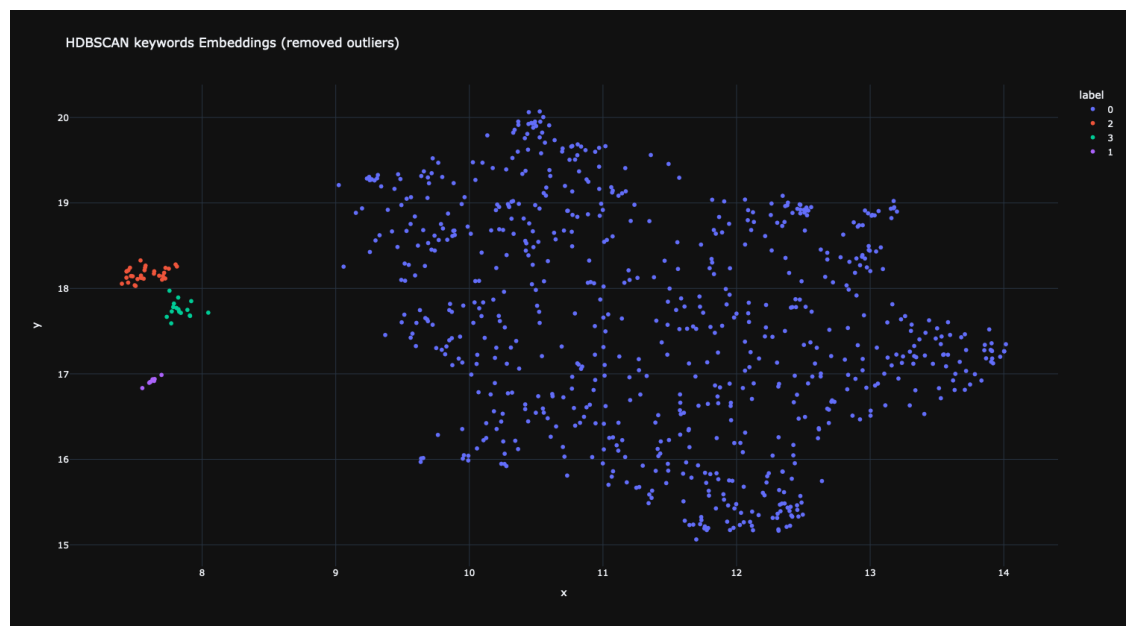

In [136]:
import matplotlib.pyplot as plt

# Read the PNG file
img_3 = plt.imread("hdbscan_kds_noout.png")

# Display the image
plt.figure(figsize=(20, 8)) 
plt.imshow(img_3)
plt.axis('off')  # Hide axes
plt.show()

And it visalises the clustering result for all datapoints.

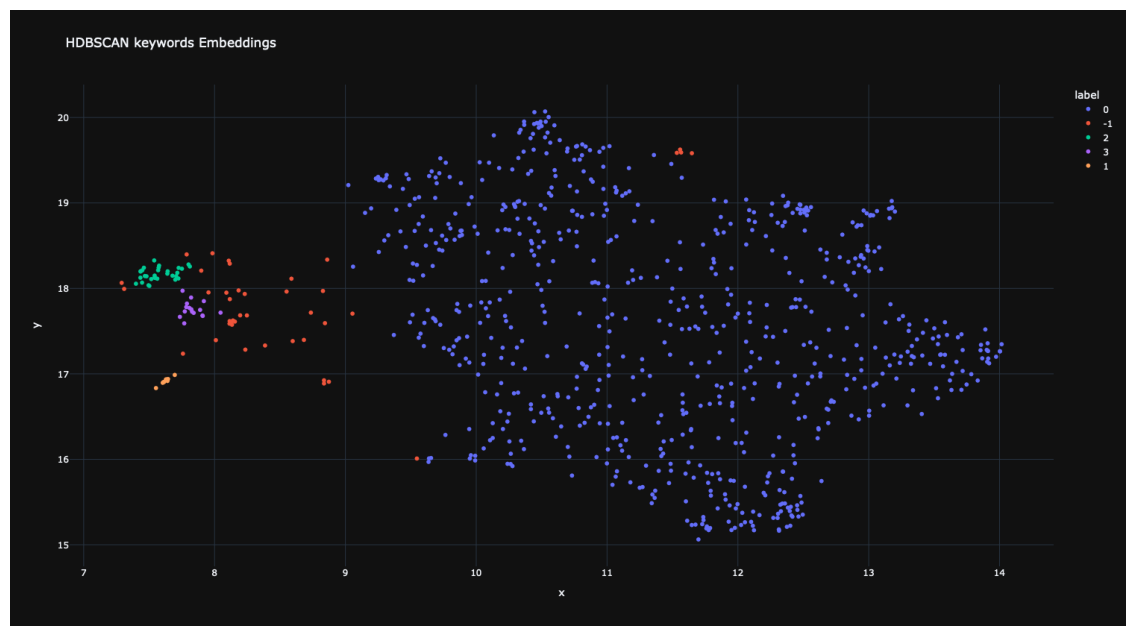

In [138]:
import matplotlib.pyplot as plt

# Read the PNG file
img_4 = plt.imread("hdbscan_kds_alldata.png")

# Display the image
plt.figure(figsize=(20, 8)) 
plt.imshow(img_4)
plt.axis('off')  # Hide axes
plt.show()

Commment: The clustering is not good.

In [104]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, homogeneity_completeness_v_measure

# Compute silhouette score
silhouette = silhouette_score(reduced_embeddings_2, labels_kds)
print(f'Silhouette Score: {silhouette}')

# Compute Calinski-Harabasz index
calinski_harabasz = calinski_harabasz_score(reduced_embeddings_2, labels_kds)
print(f'Calinski-Harabasz Index: {calinski_harabasz}')

# Compute Davies-Bouldin index
davies_bouldin = davies_bouldin_score(reduced_embeddings_2, labels_kds)
print(f'Davies-Bouldin Index: {davies_bouldin}')

Silhouette Score: 0.2667902410030365
Calinski-Harabasz Index: 92.59326747779595
Davies-Bouldin Index: 1.0385308288248873
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Comment: Silhouette Score is increased, indicating the simiarity between data points and its own cluster is improved. However, Calinski-Harabasz Index is decreased, indicating the poorer compactness and separation. Davies-Bouldin Index remains around 1, no huge improvement of better separated clustering. Overall, the first HDBSCAN on news body is better than keywords.

In [128]:
# save the plot as a html for viewing
fig.write_html("hdbscan_body_noout.html")
# save the plot as a html for viewing
fig_2.write_html("hdbscan_body_alldata.html")
# save the plot as a html for viewing
fig_3.write_html("hdbscan_kds_noout.html")
# save the plot as a html for viewing
fig_4.write_html("hdbscan_kds_alldata.html")